# Using Large Language Models 

In [1]:
# hide
with open("/home/schamponn/dev/projects/llm/key", "r") as f:
    api_key = f.read()

import logging

httpx_logger = logging.getLogger("httpx")
httpx_logger.setLevel(logging.WARNING)


import pandas as pd
from skfin.datasets_ import load_fomc_statements
from skfin.text import show_text
from skfin.plot import *
from IPython.display import Image, display

## Generating estimates from news

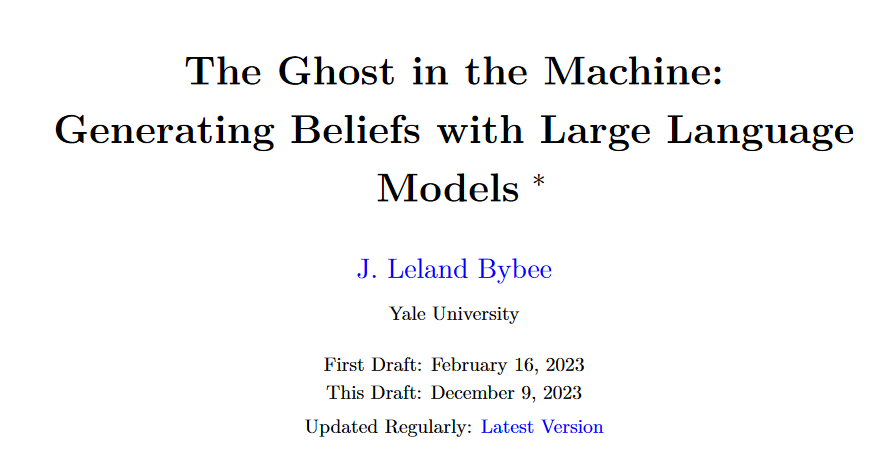

In [2]:
# hide
display(Image("images/bybee_title.png", width=600))

The main objective of the paper is to introduce a methodology for generating economic expectations using large language models (LLMs) applied to historical news data, and to explore the implications of these generated expectations for understanding economic sentiment and behavioral theories of bubbles.

More precisely, the research uses OpenAI's GPT-3.5, to generate economic expectations from historical news articles. The generated expectations are then compared to existing survey measures to evaluate their accuracy and used to construct a measure of economic sentiment

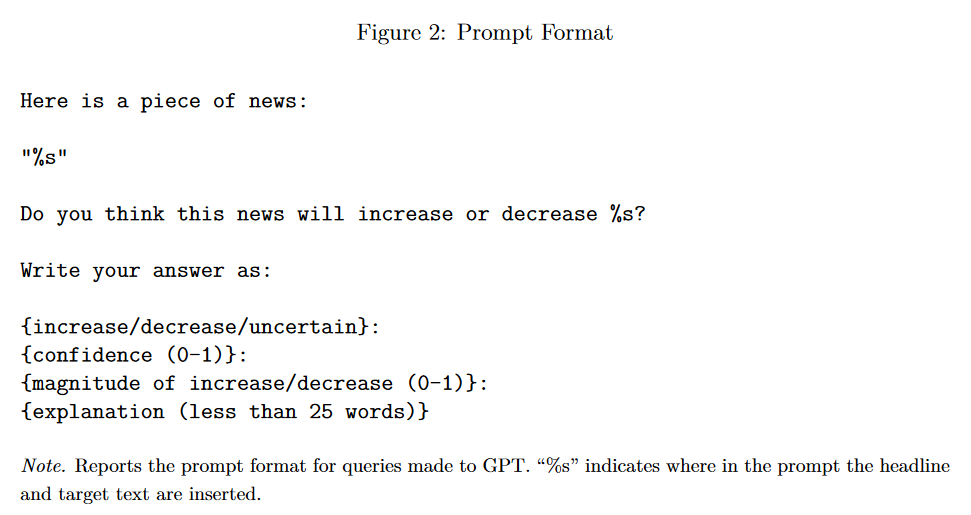

In [3]:
# hide
display(Image("images/bybee_prompt.png", width=600))

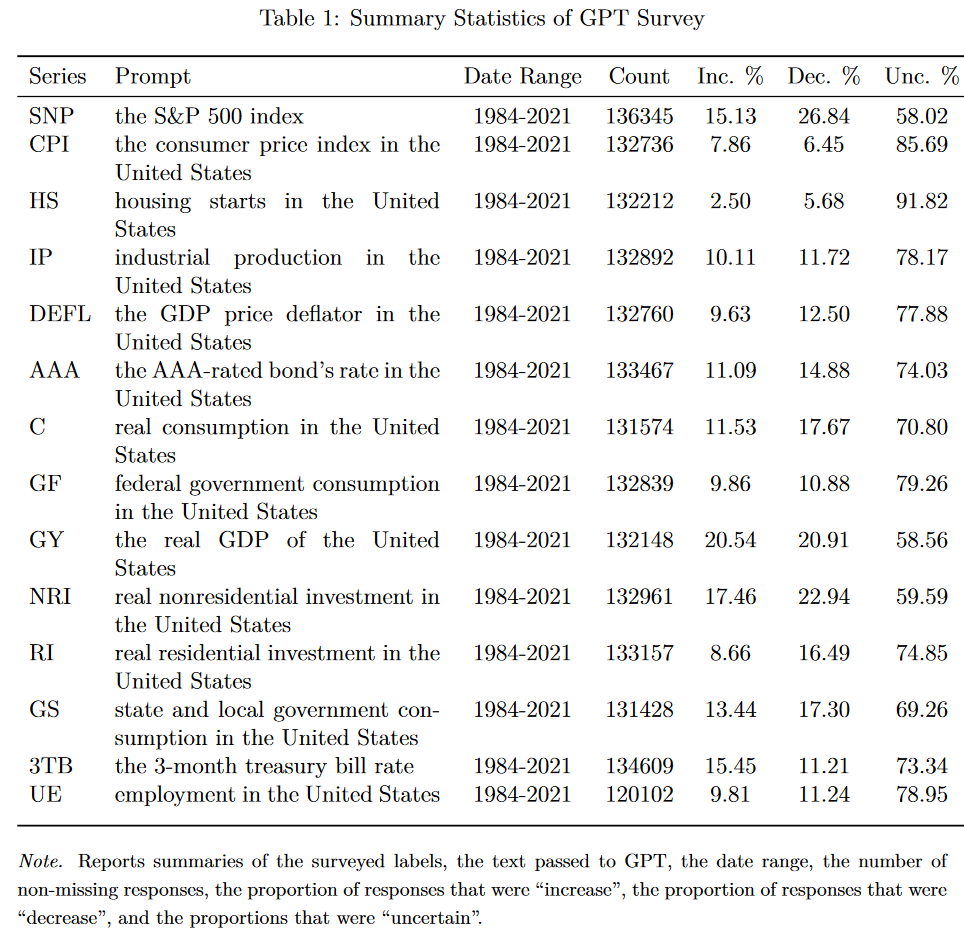

In [4]:
# hide
display(Image("images/bybee_targets.png", width=500))

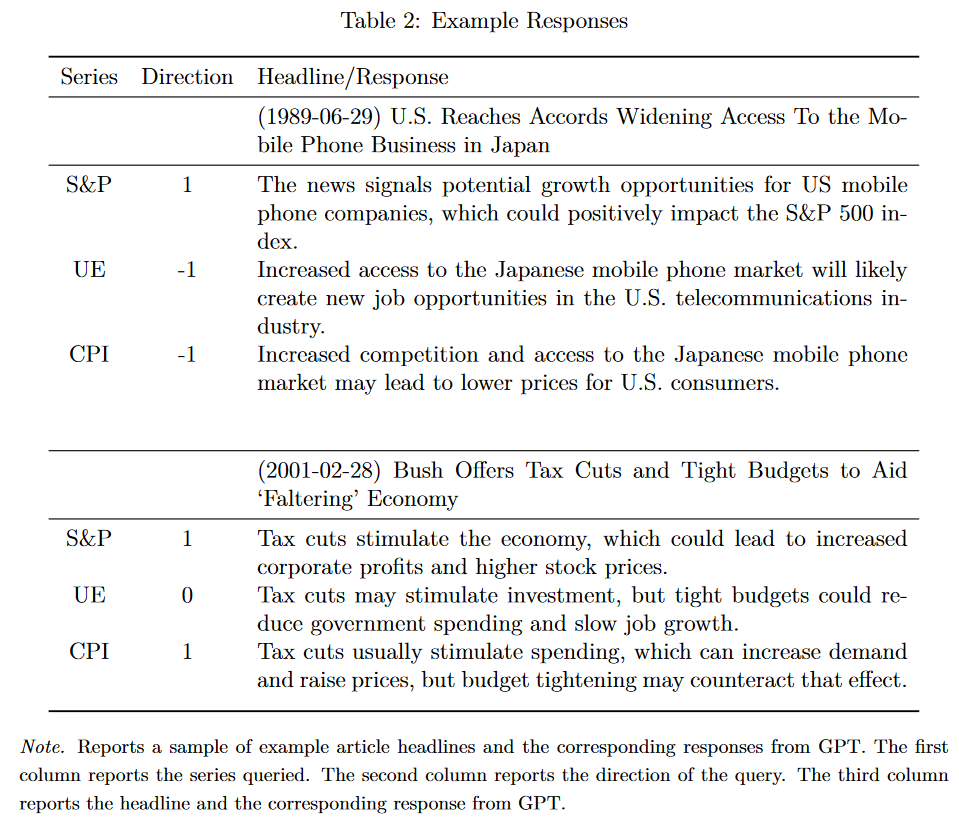

In [5]:
# hide
display(Image("images/bybee_responses.png", width=500))

The study finds that generated expectations closely match existing survey measures and capture deviations from full-information rational expectations. The generated measure of economic sentiment is positively correlated with past returns and negatively correlated with future returns, indicating its potential as a predictor of market bubbles.

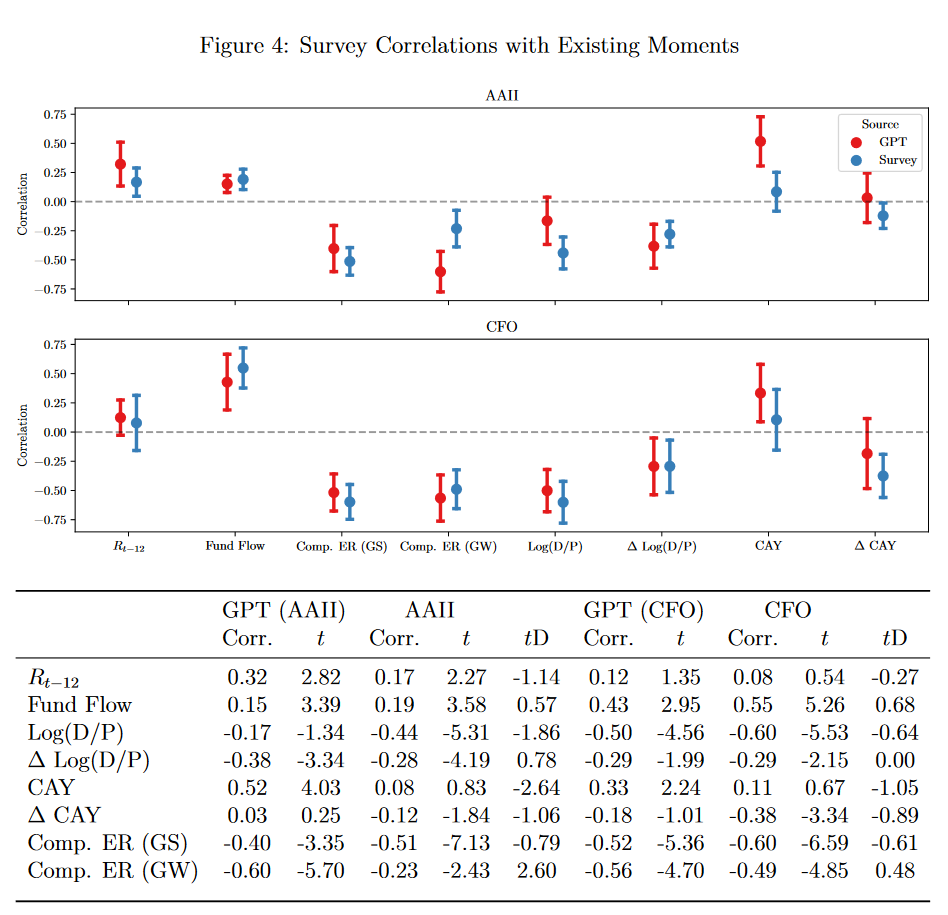

In [6]:
# hide
display(Image("images/bybee_correlation.png", width=500))

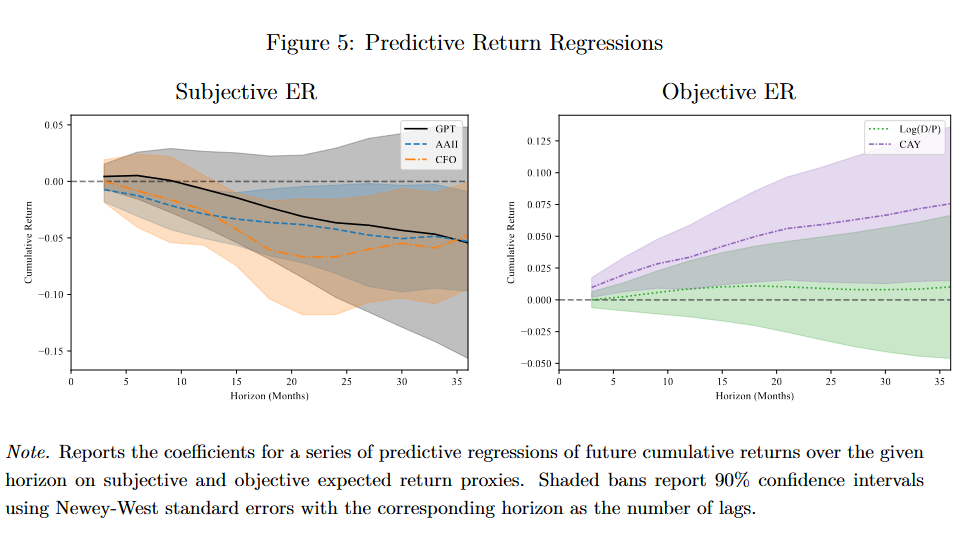

In [7]:
# hide
display(Image("images/bybee_future_returns.png", width=500))

In this notebook, we illustrate how to use `Large Language Models` (LLM), in particular models by Openai to extract information for each document of a corpus. The corpus that we will use is the collection of statements by the US Federal Reserve since 1999. 

In particular, given that Openai only proposes commercial LLMs, you need to have created an account and been provided a key. In the cell below you can paste the key: `api_key=sk-...`. Alternatively (as done below), you can put in a file call "key." and call the file. 

## LLM wrapper 

The following functions in `llm.py` allows to access language models by `openai`. 

In [8]:
%%writefile ../skfin/llm.py
import os
import ssl
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import pandas as pd
from openai import OpenAI
from tenacity import retry, stop_after_attempt, wait_exponential
import httpx

ssl._create_default_https_context = ssl._create_unverified_context


@retry(wait=wait_exponential(multiplier=1, min=6, max=10), stop=stop_after_attempt(5))
def apply_prompt_single_text(
    text,
    content_function,
    response_format,
    nested_response=False,
    model="gpt-4o-mini",
    max_new_tokens=2048,
    temperature=0,
    api_key=None,
):
    """Apply a specified prompt to a single text input using an OpenAI GPT model, and format the response.

    This function retries on failure with an exponential backoff strategy up to 5 attempts.

    Args:
        text (str): The input text to be processed by the prompt.
        content_func (callable): A function that takes a single string argument (text) and returns a formatted string.
        response_format (ResponseFormat): An instance specifying the desired format of the response.
        model (str, optional): The identifier for the model to use. Defaults to "gpt-4o-mini".
        max_new_tokens (int, optional): The maximum number of new tokens to generate in the response. Defaults to 2048.
        temperature (float, optional): Sampling temperature to use for the response generation. A value closer to 0 makes the output more deterministic. Defaults to 0.
        api_key (str, optional): OpenAi key. Defaults to None, in which case, it loaded in the local folder.

    Returns:
        dict: A dictionary where keys correspond to the properties specified in the response format's JSON schema,
              and values are the parsed responses from the model. Returns 'NA' if no output is generated.

    Raises:
        openai.error.OpenAIError: If fails to get a response after the specified retry attempts.
    """

    messages = [
        {
            "role": "system",
            "content": "Assume the role of a financial analyst.",
        },
        {
            "role": "user",
            "content": content_function(text),
        },
    ]
    if api_key is None:
        with open("key", "r") as f:
            api_key = f.read()
    client = OpenAI(api_key=api_key, 
                    http_client=httpx.Client(verify= os.environ.get("REQUESTS_CA_BUNDLE")))
    completion = client.beta.chat.completions.parse(
        model=model,
        messages=messages,
        response_format=response_format,
        max_tokens=max_new_tokens,
        temperature=0,
        seed=42,
        logprobs=True,
        top_logprobs=10,
        top_p=1,
    )
    message = completion.choices[0].message
    if message.parsed:
        keys = list(response_format.model_json_schema()["properties"].keys())
        output = {k: message.parsed.__dict__[k] for k in keys}
        if nested_response:
            assert len(output) == 1
            output = output[list(output.keys())[0]]
            assert isinstance(output, list)
            k, v = output[0].model_json_schema()["properties"].keys()
            output = pd.Series({c.__dict__[k]: c.__dict__[v] for c in output})
    else:
        print("No output")
        output = "NA"

    return output


def apply_prompt(
    dataframe,
    content_function,
    response_format,
    nested_response=False,
    model="gpt-4o-mini",
    text_column="text",
    max_workers=25,
    sequential=False,
    return_dataframe=True,
    stacked_dataframe=False, 
    api_key=None,
):
    """
    Apply a specified prompt to a DataFrame containing text data using an OpenAI GPT model.

    This function can process the text data either sequentially or concurrently using a thread pool.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the text data to be processed.
        content_function (callable): A function that takes a single string argument (text) and returns a formatted string.
        response_format (ResponseFormat): An instance specifying the desired format of the response.
        text_columns (str, optional): The column name in the DataFrame that contains the text data. Defaults to 'text'.
        max_workers (int, optional): The maximum number of worker threads to use for concurrent execution. Defaults to 25.
        sequential (bool, optional): If True, process the text data sequentially. If False, process the data concurrently. Defaults to False.
        return_dataframe (bool, optional): If True, return the results as a new DataFrame. If False, return the results as a list. Defaults to True.
        api_key (str, optional): OpenAi key. Defaults to None, in which case, it loaded in the local folder.

    Returns:
        pd.DataFrame or list: The processed output. A DataFrame if `return_dataframe` is True, otherwise a list.
    """

    texts = dataframe[text_column].values

    if sequential:
        results = [
            apply_prompt_single_text(
                text,
                content_function=content_function,
                response_format=response_format,
                nested_response=nested_response,
                model=model,
                api_key=api_key,
            )
            for text in texts
        ]
    else:
        apply_prompt_single_text_partial = partial(
            apply_prompt_single_text,
            content_function=content_function,
            response_format=response_format,
            nested_response=nested_response,
            model=model,
            api_key=api_key,
        )
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(apply_prompt_single_text_partial, texts))

    if return_dataframe:
        if stacked_dataframe:
            return pd.concat({dataframe.index[i]: pd.DataFrame(d) for i, d in enumerate(results)})
        else:
            return pd.DataFrame(results, index=dataframe.index)
    else:
        return results

Overwriting ../skfin/llm.py


In the function above (and the analysis below), the baseline model is `gpt-4o-mini`.

## Measuring hawkishness in FOMC statements

In [9]:
statements = load_fomc_statements(force_reload=False, cache_dir="../nbs/data")

INFO:skfin.dataloaders.cache:Loading from cache : ../nbs/data/fomc_statements.parquet


In [10]:
text = statements["text"].iloc[0]
text

"The Federal Reserve released the following statement after today's Federal Open Market Committee meeting: While the FOMC did not take action today to alter the stance of monetary policy, the Committee was concerned about the potential for a buildup of inflationary imbalances that could undermine the favorable performance of the economy and therefore adopted a directive that is tilted toward the possibility of a firming in the stance of monetary policy. Trend increases in costs and core prices have generally remained quite subdued. But domestic financial markets have recovered and foreign economic prospects have improved since the easing of monetary policy last fall. Against the background of already-tight domestic labor markets and ongoing strength in demand in excess of productivity gains, the Committee recognizes the need to be alert to developments over coming months that might indicate that financial conditions may no longer be consistent with containing inflation."

With the following prompt, we ask the model to qualify Fed statements in terms of hawkishness/dovishness. We also insist on receiving a single-word answer. 

In [11]:
from skfin.llm import apply_prompt
from typing import Literal
from pydantic import BaseModel


def content_hawkishness(text):
    return f"""Act as a financial analyst. What is the monetary policy hawkishness of this text?
    Please choose an answer from hawkish, dovish, neutral or unknown and provide a probability and a short explanation. 

Text: {text}"""


class format_hawkishness(BaseModel):
    hawkishness: Literal["hawkish", "neutral", "dovish", "unknown"]
    probability: float
    explanation: str

In [12]:
df = apply_prompt(
    statements,
    content_function=content_hawkishness,
    response_format=format_hawkishness,
    text_column="text",
    api_key=api_key,
)

INFO:openai._base_client:Retrying request to /chat/completions in 0.376636 seconds


In [13]:
show_text(df, text_column="explanation", n=5)

,hawkishness,probability,explanation
release_date,,,
2022-09-21,hawkish,0.85,"The text indicates a strong commitment to combating inflation, with the Committee raising the federal funds rate and anticipating ongoing increases. This suggests a hawkish stance, as the focus is on tightening monetary policy to address elevated inflation levels. The mention of monitoring economic indicators and being prepared to adjust policy further supports a hawkish outlook."
2006-10-25,neutral,0.70,"The text indicates a balanced view on monetary policy. While it acknowledges elevated inflation pressures and the potential need for further tightening, it also notes that inflation may moderate and that the decision on future actions will depend on evolving economic conditions. This suggests a cautious approach rather than a strong inclination towards hawkishness."
2020-07-29,dovish,0.85,"The text indicates a strong commitment to supporting the economy through low interest rates and asset purchases, which are characteristic of a dovish stance. The Federal Reserve is focused on maximum employment and price stability, and it explicitly states that it will maintain the current low target range for the federal funds rate until confident in economic recovery. The emphasis on monitoring economic conditions and the ongoing public health crisis further supports a dovish outlook."
2014-12-17,dovish,0.75,"The text indicates a commitment to maintaining low interest rates (0 to 1/4 percent) for an extended period, suggesting a dovish stance. The emphasis on being 'patient' in normalizing monetary policy and the acknowledgment that inflation is currently below the target further support this dovish outlook. While there is recognition of potential future rate increases if conditions improve, the overall tone leans towards supporting economic growth and employment rather than tightening monetary policy."
2003-08-12,dovish,0.85,"The text indicates that the Federal Open Market Committee is maintaining an accommodative monetary policy stance, suggesting a focus on supporting economic activity rather than tightening policy. The mention of concerns about low inflation and the intention to keep rates low for an extended period further supports a dovish outlook."


Checking that indeed we received at most the four options. (It seems that the models rarely says "I don't know.")

In [14]:
df["hawkishness"].value_counts()

dovish     120
neutral     61
hawkish     46
Name: hawkishness, dtype: int64

In [15]:
df["probability"].value_counts()

0.85    125
0.75     66
0.70     34
0.60      1
0.65      1
Name: probability, dtype: int64

To get an intuition from the output of the LLM, we problem the cumulative difference of the dummies `hawkish - dovish`. We see clearly the tightening and accomodating phases of monetary policy:

- 1999 - 2001: tightening until the dot-com burst 
- 2001 - 2004: loosening of monetary policy 
- 2004 - 2007: tightening
- 2007 - 2017: long experiment with loosening, including with Quantitative Easing 
- 2017 - 2019: Quantitative tightening
- 2019 - 2021: economic slowdown (2019) preceding the Covid intervention
- 2022 - today: tightening due to high inflation

The picture below shows  `hawkish-dovish` LLM score with a rolling 1-year (= 8 FOMC meetings).

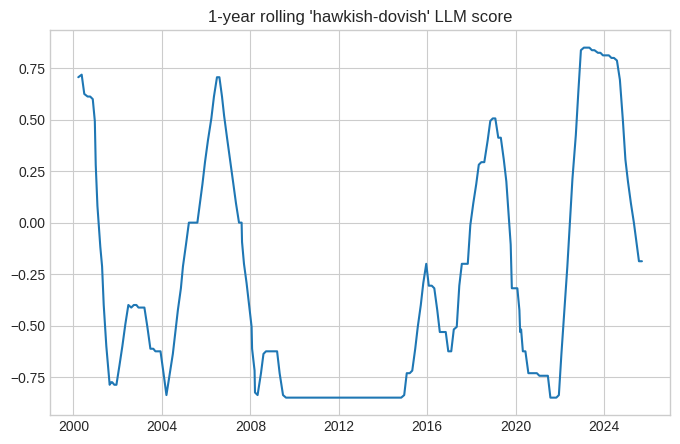

In [16]:
statements_ = statements.join(
    pd.get_dummies(df["hawkishness"], dtype=float).mul(df["probability"], axis=0)
).join(df["explanation"])

line(
    statements_.pipe(lambda x: x["hawkish"].sub(x["dovish"])).rolling(window=8).mean(),
    legend=False,
    title="1-year rolling 'hawkish-dovish' LLM score",
)

## Explaining hawkishness

Beyond the simple validation of the LLM score in the previous section, we can go deeper and identify the words associated with hawkishness (or dovishness) as interpreted by the language model. To do so, we run a regression where the target is the LLM score and the features are `tfidf` values for the main tokens. 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

In [18]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0075)),
    ]
)

In [19]:
X = statements_["text"]
interpret_coefs = {}
for c in ["hawkish", "neutral", "dovish"]:
    y = statements_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(
        np.transpose(est.named_steps["reg"].coef_), index=vocab_
    )
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}

Words associated to tightening are on the `hawkish` side ("raise target", "pressures", "inflation", etc). A bit more mixed resuts on the other side. 

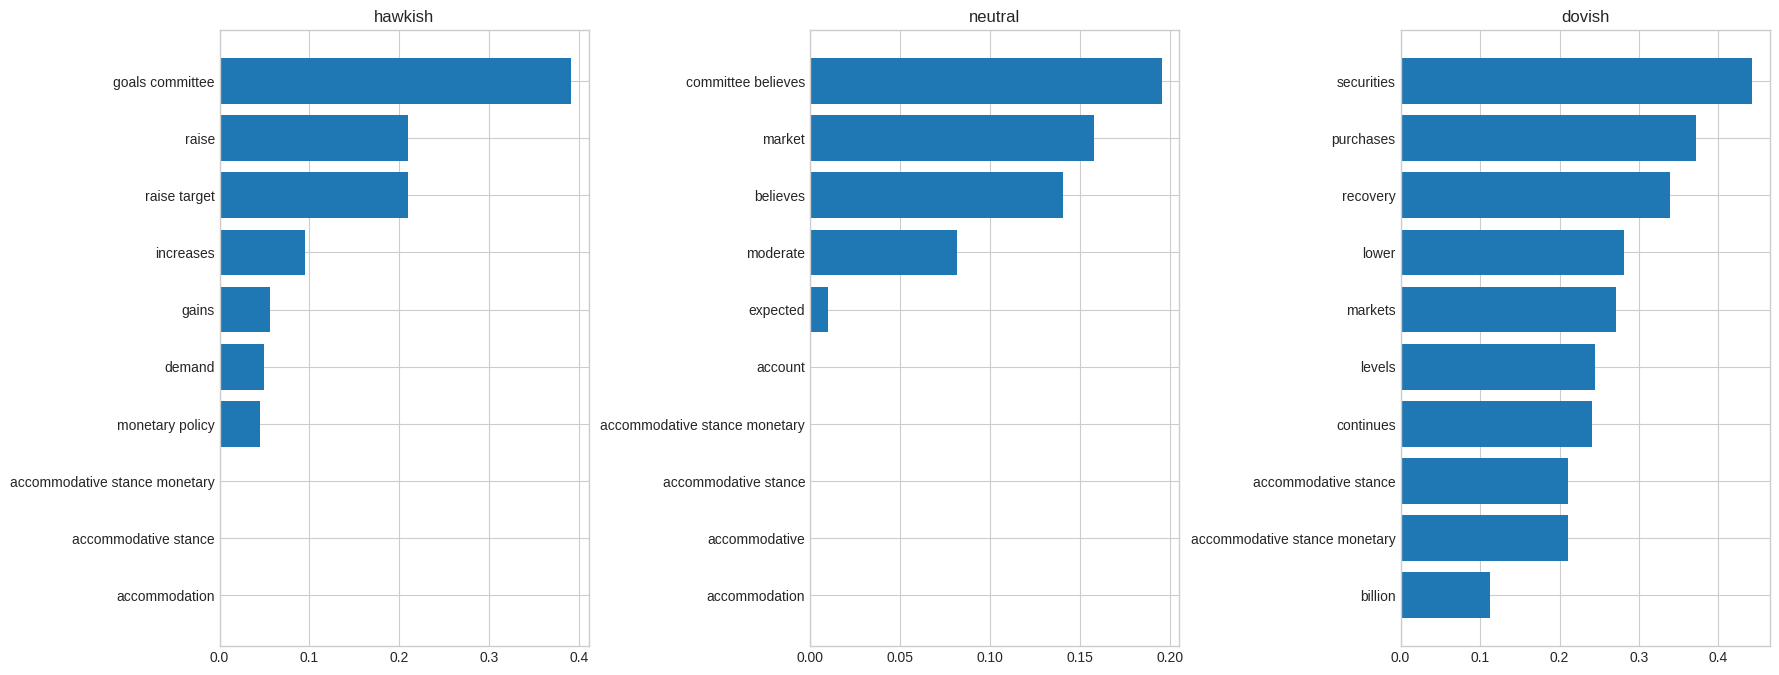

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0.6)
for i, (k, v) in enumerate(d.items()):
    bar(v, horizontal=True, ax=ax[i], title=k)

Instead of using the actual text, we can use the explanation provided by chatGPT. 

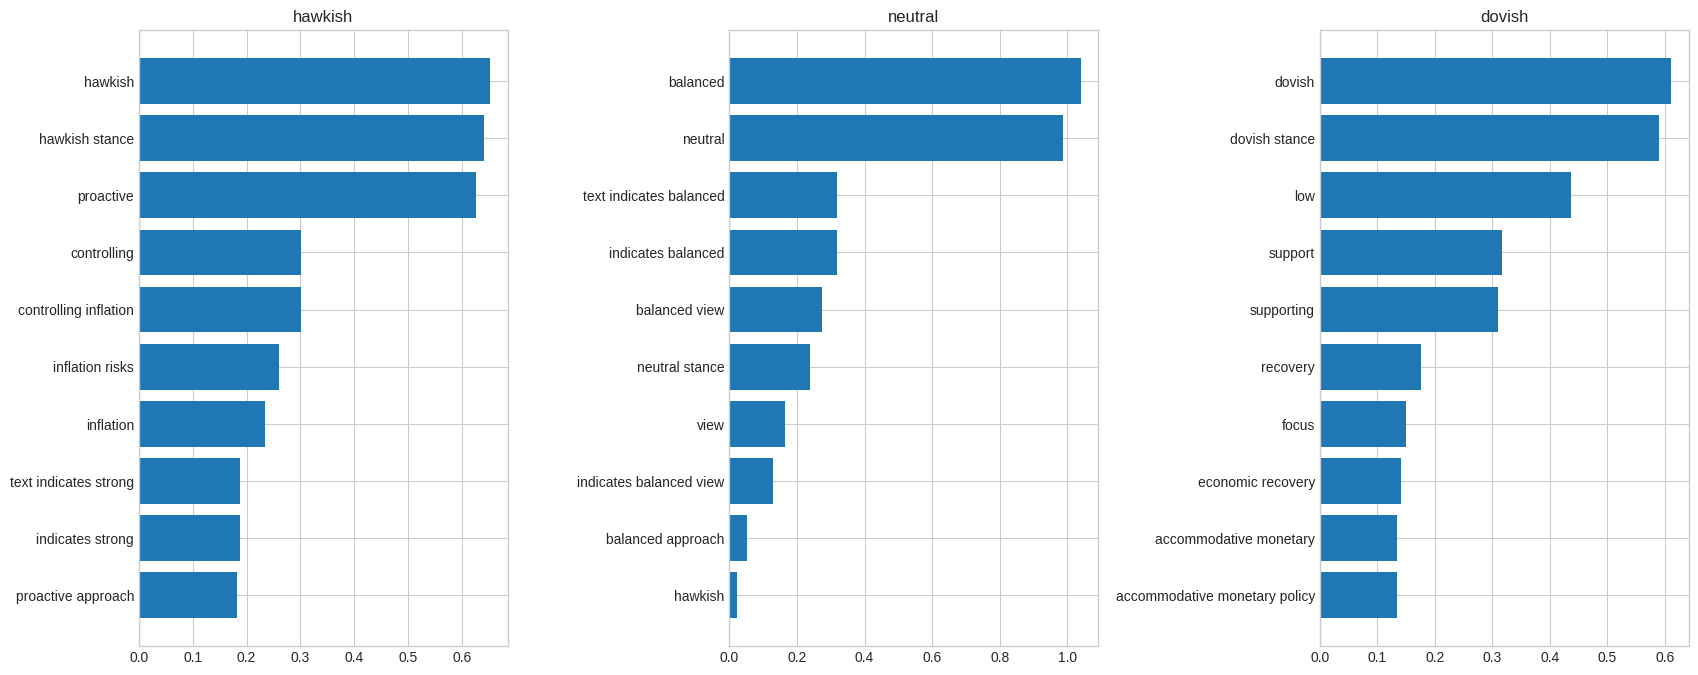

In [21]:
X = statements_["explanation"]
interpret_coefs = {}
for c in ["hawkish", "neutral", "dovish"]:
    y = statements_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(
        np.transpose(est.named_steps["reg"].coef_), index=vocab_
    )
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}


fig, ax = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0.6)
for i, (k, v) in enumerate(d.items()):
    bar(v, horizontal=True, ax=ax[i], title=k)

## Topics in FOMC statements

In [22]:
def content_topics(text):
    return f"""Please assess the importance for each of the following topics in the text below: 
    inflation, employment, economic growth, financial stability, interest rates and the yield curve, fiscal policy, consumer confidence, and market expectations. 
    Provide a score between 0 and 1 for each.

Text: {text}"""


class format_topics(BaseModel):
    inflation: float
    employment: float
    economic_growth: float
    financial_stability: float
    interest_rate_and_the_yield_curve: float
    fiscal_policy: float
    consumer_confidence: float
    market_expectations: float

In [23]:
df2 = apply_prompt(
    statements,
    content_function=content_topics,
    response_format=format_topics,
    text_column="text",
    api_key=api_key,
)

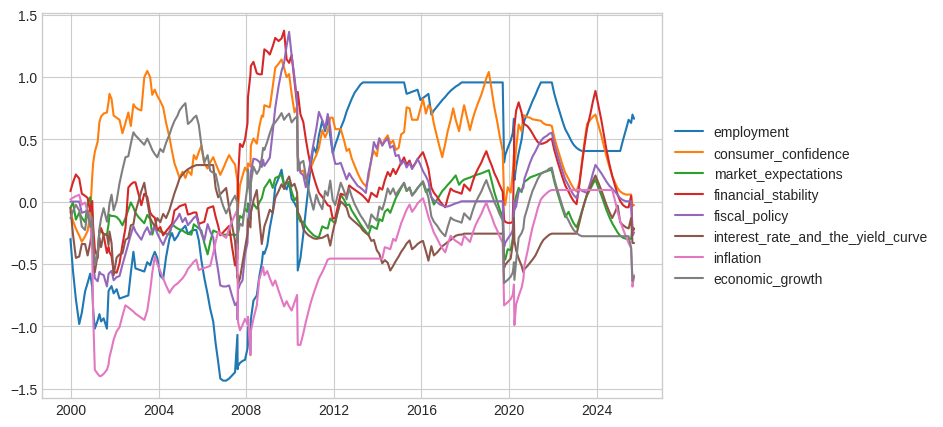

In [24]:
line(
    df2.pipe(lambda x: x.sub(x.rolling(window=12, min_periods=6).mean())),
    cumsum=True,
    legend_sharpe_ratio=False,
)

In [25]:
est_ = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=5 * 1e-4)),
    ]
)

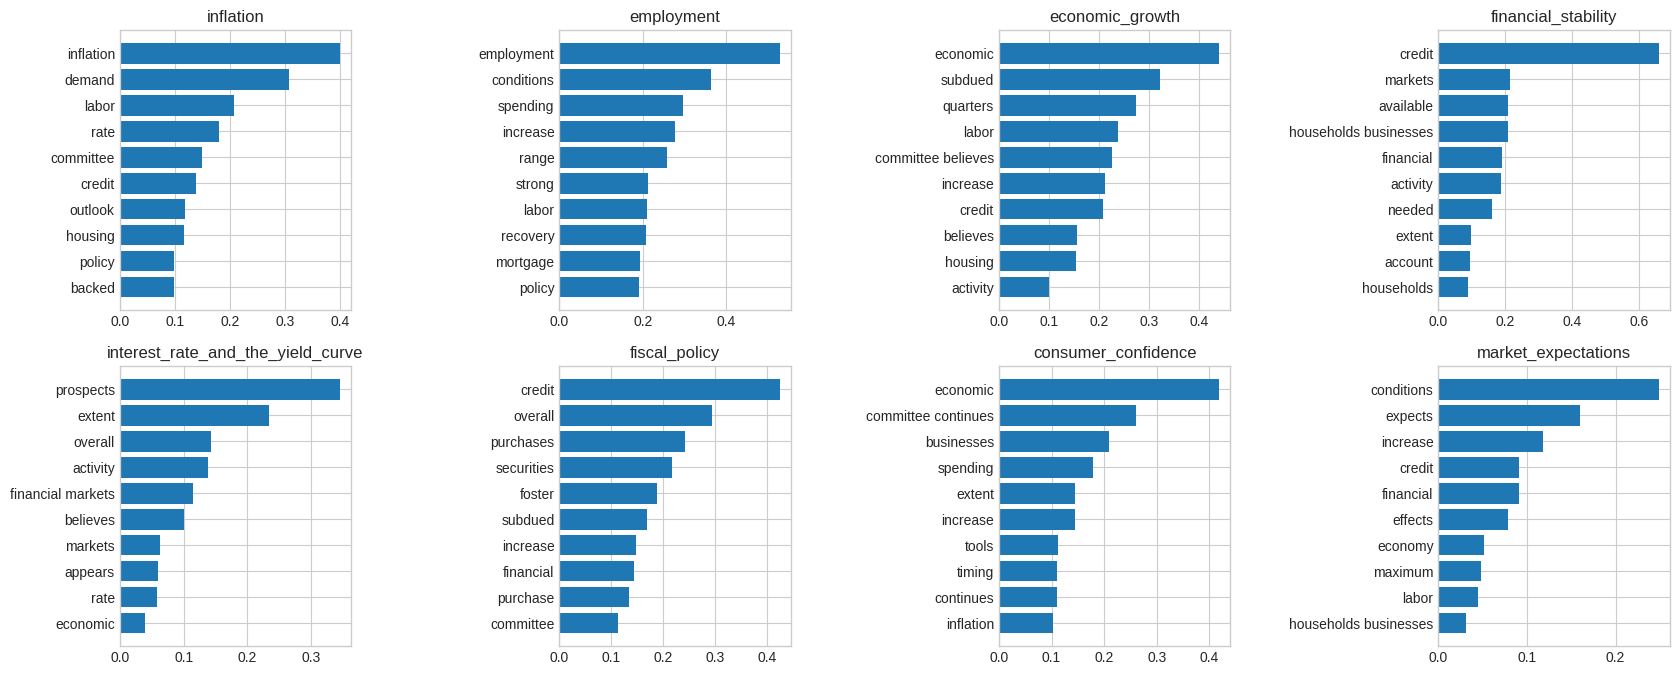

In [26]:
statements2_ = statements.join(df2)
X = statements2_["text"]
interpret_coefs = {}
for c in df2.columns:
    y = statements2_[c]
    est_.fit(X, y)
    vocab_ = pd.Series(est_.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(
        np.transpose(est_.named_steps["reg"].coef_), index=vocab_
    )
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}


fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.ravel()
fig.subplots_adjust(wspace=0.9)
for i, (k, v) in enumerate(d.items()):
    bar(v, horizontal=True, ax=ax[i], title=k)

## Predicting returns with FOMC statements

In [27]:
def content_returns(text):
    return f"""Here is a piece of news: {text}. 
    Do you think this news will increase or decrease the S&P500? Write your answer as:
    - impact: increase/decrease/uncertain:
    - confidence (0-1):
    - magnitude of impact (0-1):
    - explanation (less than 25 words)
"""


class format_returns(BaseModel):
    sp_impact: Literal["increase", "decrease", "uncertain"]
    confidence: float
    magnitude: float
    explanation: str

In [28]:
df3 = apply_prompt(
    statements,
    content_function=content_returns,
    response_format=format_returns,
    text_column="text",
    api_key=api_key,
)

In [29]:
raw_alpha = (
    pd.get_dummies(df3["sp_impact"], dtype=float)
    .mul(df3["confidence"] * df3["magnitude"], axis=0)
    .pipe(lambda x: x["increase"] - x["decrease"])
    .resample("B")
    .last()
)

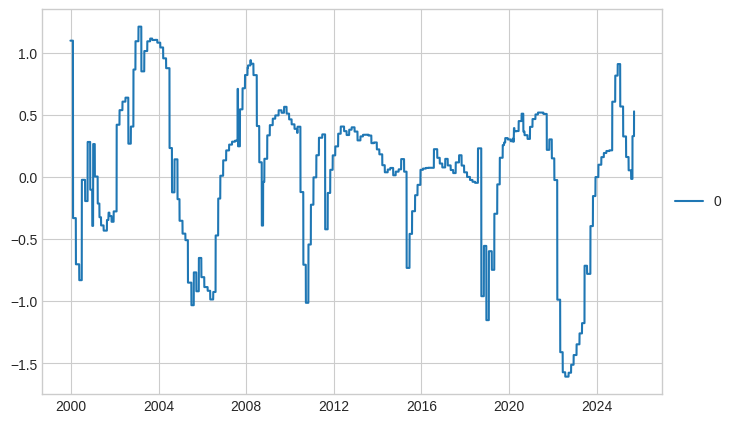

In [30]:
alpha = (
    raw_alpha.pipe(lambda x: x.sub(x.ewm(halflife=6, ignore_na=True).mean()))
    .pipe(lambda x: x.div(x.ewm(12, min_periods=6, ignore_na=True).std()))
    .ewm(halflife=63)
    .mean()
)
line(alpha)

In [31]:
from skfin.backtesting import Backtester
from skfin.mv_estimators import TimingMeanVariance
from skfin.datasets_ import load_kf_returns


def transform_y(df):
    return df.shift(-2)


ret = (
    load_kf_returns(filename="F-F_Research_Data_Factors_daily")["Daily"]
    .resample("B")
    .last()
)
data = ret.join(alpha.rename("alpha"), how="inner").fillna(0)

INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Research_Data_Factors_daily


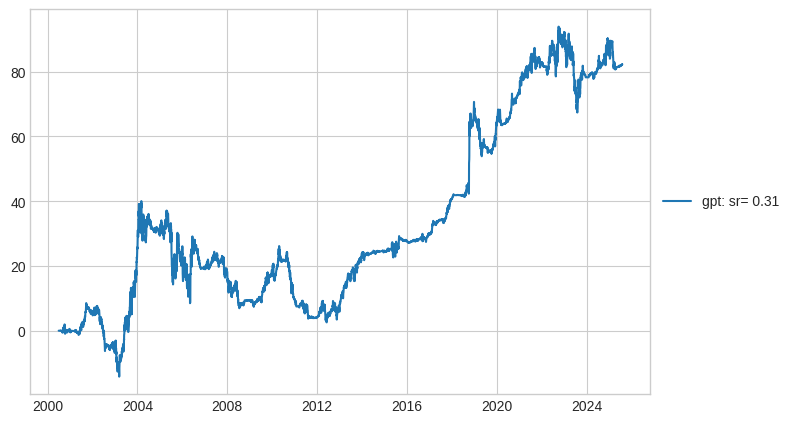

In [32]:
ret_ = data["Mkt-RF"]
y = transform_y(data["Mkt-RF"])
m = Backtester(estimator=TimingMeanVariance(), name="gpt", start_date="2000-06-30")
pnl_ = m.train(data["alpha"], y, ret_)
line(pnl_, cumsum=True)

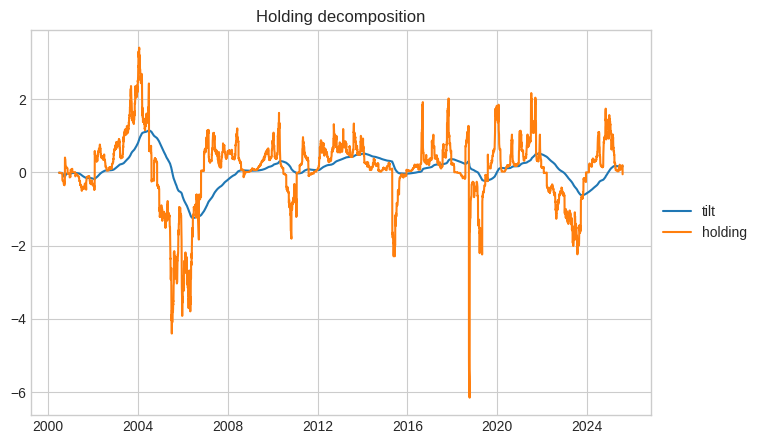

In [33]:
line(
    {"holding": m.h_, "tilt": m.h_.ewm(halflife=252).mean()},
    title="Holding decomposition",
)

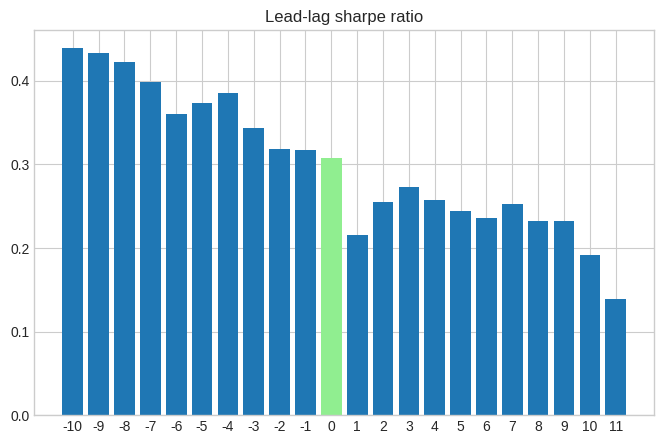

In [34]:
sr = {i: m.h_.shift(1 + i).mul(ret_).pipe(sharpe_ratio) for i in range(-10, 12)}
bar(sr, baseline=0, sort=False, title="Lead-lag sharpe ratio")

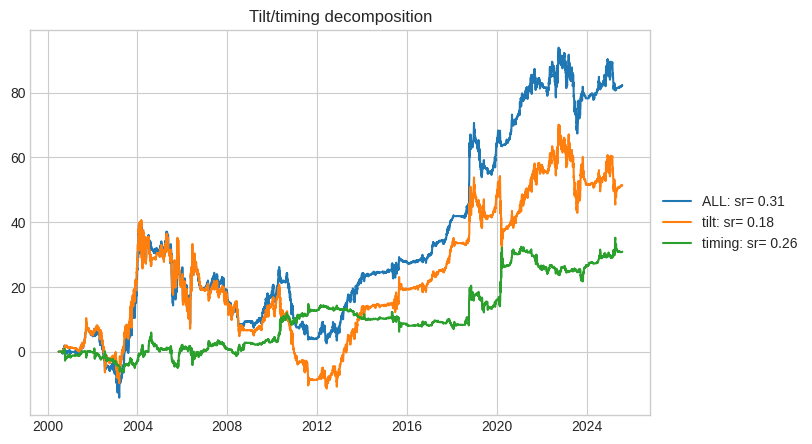

In [35]:
line(
    {
        "ALL": pnl_,
        "tilt": m.h_.ewm(halflife=12).mean().shift(1).mul(ret_).dropna(),
        "timing": m.h_.sub(m.h_.ewm(halflife=12).mean()).shift(1).mul(ret_).dropna(),
    },
    cumsum=True,
    title="Tilt/timing decomposition",
)

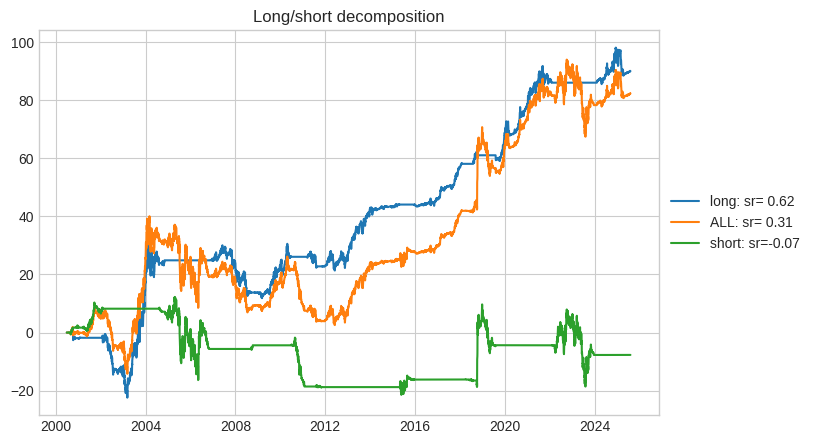

In [36]:
line(
    {
        "ALL": pnl_,
        "long": m.h_.clip(lower=0).shift(1).mul(ret_).dropna(),
        "short": m.h_.clip(upper=0).shift(1).mul(ret_).dropna(),
    },
    cumsum=True,
    title="Long/short decomposition",
)